# MINOR PROJECT EXAMPLES

In [1]:
import os
import time
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import class_weight
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import TensorBoard, ModelCheckpoint

Using TensorFlow backend.


In [2]:
drive_base_path = "../"

In [3]:
def ResNet50_Model():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # x = Dense(1000,
    #           kernel_regularizer=regularizers.l2(5e-4),
    #           activation='relu')(x)
    # x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # model.compile(loss="categorical_crossentropy", 
    #               optimizer=Adam(lr=1e-3), 
    #               metrics=["acc"])
    print(model.summary())
    return model

In [4]:
def VGG16_Model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#         layer.trainable = False

#     model.compile(loss="categorical_crossentropy", 
#                   optimizer=RMSprop(lr=1e-5), 
#                   metrics=["acc"])
    
    print(model.summary())
    return model

In [11]:
def inceptionv3_model():
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)


    model = Model(inputs=base_model.input, outputs=predictions)

#     model.compile(loss="categorical_crossentropy", optimizer=RMSprop(lr=1e-4), metrics=["accuracy"])
    print(model.summary())
    return model

In [12]:
vgg16_model = VGG16_Model()
resnet50_model = ResNet50_Model()
inceptionv3_model = inceptionv3_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

87916544/87910968 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________

In [13]:
VGG16_WEIGHT_FILE = drive_base_path + "models/checkpoint/VGG_REST.15-1.05.hdf5"
RESNET50_WEIGHT_FILE = drive_base_path + "models/checkpoint/ResNet50_REST.14-1.38.hdf5"
INCEPTIONV3_WEIGHT_FILE = drive_base_path + "models/InceptionV3Net_ISIC_cnn.h5"

vgg16_model.load_weights(VGG16_WEIGHT_FILE)
resnet50_model.load_weights(RESNET50_WEIGHT_FILE)
inceptionv3_model.load_weights(INCEPTIONV3_WEIGHT_FILE)

In [14]:
def preprocess_images(path_to_images, path_to_description, number_of_images):
    images_list = []
    y_test = []
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = number_of_images
    
    for i, filename in enumerate(tqdm(list_of_images, total=number)):
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2] # height, width

        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        image = cv2.resize(image, (new_size[1], new_size[0]))
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)

        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, 
                                    value=color)

        images_list.append(new_img)
        
        with open(path_to_description, "r") as file:
            for line in file:
                row = line.rstrip("\n").split(",")
                if row[0] == filename[0:-4]:
                    y_test.append([int(float(x)) for x in row[1:]])
        
        if  i >= number_of_images:
            break
        
    images_list = np.array(images_list)
    y_test = np.array(y_test)
    return images_list, y_test

In [15]:
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
path_to_description = drive_base_path + "dataset/ISIC2018_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"

x_test, y_test = preprocess_images(path_to_images, path_to_description, 1000)
print(x_test.shape)
print(y_test.shape)

(1001, 224, 224, 3)
(1001, 7)


In [16]:
datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    data_format="channels_last")

In [17]:
datagen.fit(x_test)

In [19]:
batch_size = 1
test_generator = datagen.flow(
                    x_test,
                    batch_size=batch_size,
                    shuffle=False)

In [20]:
Y_pred = vgg16_model.predict_generator(test_generator, steps=len(x_test) // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
test = np.argmax(y_test, axis=1)

In [21]:
classes = {
    0: 'Melanoma',
    1: 'Melanocytic nevus',
    2: 'Basal cell carcinoma',
    3: 'Actinic keratosis',
    4: 'Benign keratosis',
    5: 'Dermatofibroma',
    6: 'Vascular lesion'
}

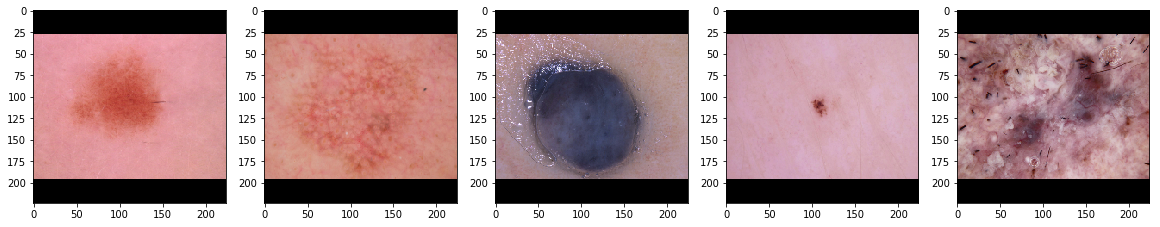

Predicted Label: 
Melanocytic nevus	Actinic keratosis	Melanocytic nevus	Melanocytic nevus	Actinic keratosis	

True Label: 
Melanocytic nevus	Actinic keratosis	Melanocytic nevus	Melanocytic nevus	Basal cell carcinoma	

In [30]:
fig=plt.figure(figsize=(20, 5))
columns = 5
rows = 1

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_test[i-1])

plt.show()
time.sleep(5)

print("Predicted Label: ")
for i in range(0, columns*rows):
    print(classes[y_pred[i]], end="\t")

print("\n")
print("True Label: ")
for i in range(0, columns*rows):
    print(classes[test[i]], end="\t")


In [31]:
Y_pred = resnet50_model.predict_generator(test_generator, steps=len(x_test) // batch_size)
y_pred = np.argmax(Y_pred, axis=1)

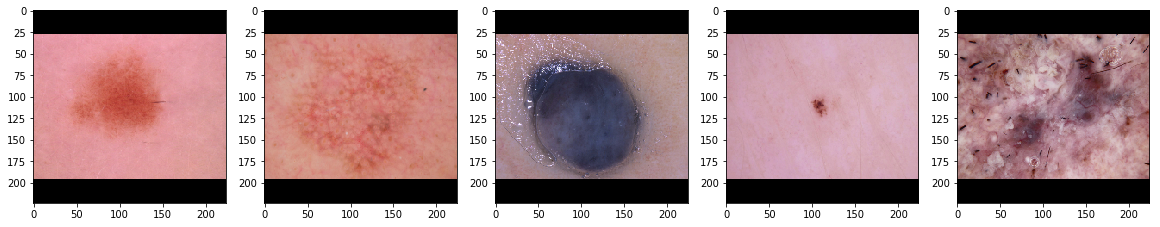

Predicted Label: 
Melanocytic nevus	Melanoma	Melanocytic nevus	Melanocytic nevus	Melanoma	

True Label: 
Melanocytic nevus	Actinic keratosis	Melanocytic nevus	Melanocytic nevus	Basal cell carcinoma	

In [32]:
fig=plt.figure(figsize=(20, 5))
columns = 5
rows = 1

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_test[i-1])

plt.show()
time.sleep(5)

print("Predicted Label: ")
for i in range(0, columns*rows):
    print(classes[y_pred[i]], end="\t")

print("\n")
print("True Label: ")
for i in range(0, columns*rows):
    print(classes[test[i]], end="\t")

In [34]:
def preprocess_images(path_to_images, path_to_description, number_of_images):
    images_list = []
    y_test = []
    
    input_size = 299
    list_of_images = os.listdir(path_to_images)
    number = number_of_images
    
    for i, filename in enumerate(tqdm(list_of_images, total=number)):
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2] # height, width

        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        image = cv2.resize(image, (new_size[1], new_size[0]))
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)

        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, 
                                    value=color)

        images_list.append(new_img)
        
        with open(path_to_description, "r") as file:
            for line in file:
                row = line.rstrip("\n").split(",")
                if row[0] == filename[0:-4]:
                    y_test.append([int(float(x)) for x in row[1:]])
        
        if  i >= number_of_images:
            break
        
    images_list = np.array(images_list)
    y_test = np.array(y_test)
    return images_list, y_test

In [35]:
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
path_to_description = drive_base_path + "dataset/ISIC2018_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"

x_test, y_test = preprocess_images(path_to_images, path_to_description, 1000)
print(x_test.shape)
print(y_test.shape)

(1001, 299, 299, 3)
(1001, 7)


In [36]:
datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    data_format="channels_last")

In [37]:
batch_size = 1
test_generator = datagen.flow(
                    x_test,
                    batch_size=batch_size,
                    shuffle=False)

In [39]:
Y_pred = inceptionv3_model.predict_generator(test_generator, steps=len(x_test) // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
test = np.argmax(y_test, axis=1)

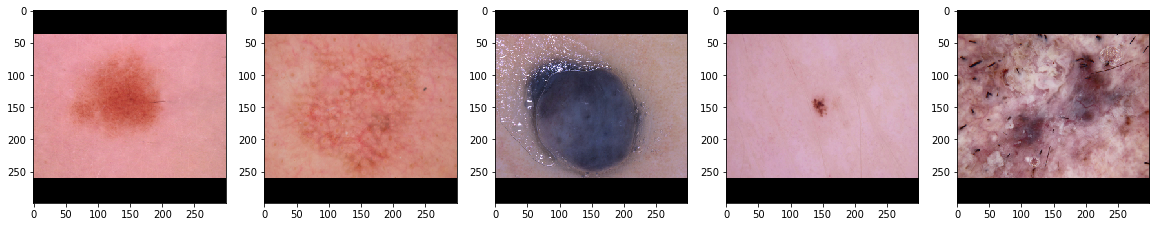

Predicted Label: 
Benign keratosis	Melanocytic nevus	Melanocytic nevus	Melanocytic nevus	Melanocytic nevus	

True Label: 
Melanocytic nevus	Actinic keratosis	Melanocytic nevus	Melanocytic nevus	Basal cell carcinoma	

In [40]:
fig=plt.figure(figsize=(20, 5))
columns = 5
rows = 1

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_test[i-1])

plt.show()
time.sleep(5)

print("Predicted Label: ")
for i in range(0, columns*rows):
    print(classes[y_pred[i]], end="\t")

print("\n")
print("True Label: ")
for i in range(0, columns*rows):
    print(classes[test[i]], end="\t")